### Загрузка данных

Гайд по скачиванию:
https://www.metagenomics.wiki/tools/fastq/ncbi-ftp-genome-download

In [ ]:
import gzip

!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz'
!wget 'https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz'

!gunzip GCF_000355675.1_ASM35567v1_genomic.fna.gz
!gunzip GCF_000355675.1_ASM35567v1_genomic.gbff.gz

--2024-11-09 22:04:09--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.fna.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.12, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1168222 (1.1M) [application/x-gzip]
Saving to: ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’

GCF_000355675.1_ASM 100%[===================>]   1.11M  69.0KB/s    in 18s     

2024-11-09 22:04:30 (61.9 KB/s) - ‘GCF_000355675.1_ASM35567v1_genomic.fna.gz’ saved [1168222/1168222]

--2024-11-09 22:04:30--  https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/355/675/GCF_000355675.1_ASM35567v1/GCF_000355675.1_ASM35567v1_genomic.gbff.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.12, 130.14.250.10, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.2

### Reading sequences

In [1]:
!pip install bio

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 KB 1.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.6/64.6 KB 14.4 MB/s eta 0:00:00


In [2]:
from Bio import SeqIO
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt

seq = None
gb = None

# считываем скачанные файлы
for record in SeqIO.parse("./GCF_000355675.1_ASM35567v1_genomic.fna", "fasta"):
    seq = record.seq

for record in SeqIO.parse('./GCF_000355675.1_ASM35567v1_genomic.gbff', 'genbank'):
  gb = record

In [3]:
_start, _end = gb.features[0].location.start, None

ncod = []
cod = []

# записываем кодирующие и некодирующие последовательности
for i in range(len(gb.features)):
  feature = gb.features[i]
  fseq = feature.extract(seq)

  _end = feature.location.start

  if feature.type == 'CDS' and fseq[:3] == 'ATG' and len(fseq) % 3 == 0:
    cod.append(fseq.__str__())

    if len(seq[_start:_end]) != 0:
      ncod.append(seq[_start:_end].__str__())

    _start = feature.location.end

### Initial probabilities

In [4]:
def seq_probs(seq):
  return np.array([
      seq.count('T'), seq.count('C'),
      seq.count('A'), seq.count('G')
    ]) / len(seq)

def cod_probs(seq):
  res = []
  for i in range(3):
    res.append(seq_probs(seq[i::3]))
  return np.array(res)

def make_table1(cod_seqs, ncod_seqs):
  table1 = pd.DataFrame(np.vstack((cod_probs(''.join(cod_seqs)), seq_probs(''.join(ncod_seqs)))).T,
                       index=['T', 'C', 'A', 'G'],
                       columns=[f'pos{i}' for i in range(1, 4)] + ['nc'])
  return table1

In [5]:
t1 = make_table1(cod, ncod)
t1

,pos1,pos2,pos3,nc
T,0.181143,0.296068,0.315043,0.273024
C,0.206706,0.227065,0.233173,0.228923
A,0.256916,0.302111,0.238480,0.276478
G,0.355236,0.174755,0.213304,0.221574


### Transition probabilities

In [6]:
def cod_dprobs(seqs):
  dcounts = dict(
    zip([1, 2, 3],
        [dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                  [0] * 16)) for i in range(3)])
    )
  for seq in seqs:
    for i in range(1, len(seq)):
      dcounts[i % 3 + 1][seq[i-1:i+1]] += 1
  return get_probs(dcounts)

def ncod_dprobs(seqs):
    dcounts =dict(zip([''.join(pair) for pair in product('TCAG', repeat=2)],
                    [0] * 16))
    for seq in seqs:
      for i in range(1, len(seq)):
        dcounts[seq[i-1:i+1]] += 1

    return get_probs({0: dcounts})[0]

def get_probs(dcounts):
  for pos in dcounts:
    nuc_groups = dict(zip('TCAG', [0] * 4))
    for dup in dcounts[pos]:
      nuc_groups[dup[0]] += dcounts[pos][dup]
    for dup in dcounts[pos]:
      dcounts[pos][dup] /= nuc_groups[dup[0]]
  return dcounts

def make_table2(cod_seqs, ncod_seqs):
  table2 = pd.DataFrame(cod_dprobs(cod_seqs))
  table2[4] = pd.Series(ncod_dprobs(ncod_seqs))
  table2.rename(columns=dict(zip(np.arange(1, 5),
                                 [f'pos{i}' for i in range(1, 4)] + ['nc'])),
                inplace=True)
  table2.index = [prob_notation(idx) for idx in table2.index.values]
  return table2

def prob_notation(st):
  return st[1] + '|' + st[0]

In [7]:
t2 = make_table2(cod, ncod)
t2

,pos1,pos2,pos3,nc
T|T,0.185482,0.497862,0.316308,0.318271
C|T,0.189688,0.199483,0.179891,0.208911
A|T,0.249131,0.172440,0.221458,0.243934
G|T,0.375698,0.130215,0.282343,0.228884
T|C,0.185235,0.248571,0.269872,0.252402
C|C,0.156213,0.197930,0.244217,0.214059
A|C,0.276197,0.315174,0.244461,0.286765
G|C,0.382355,0.238325,0.241449,0.246775
T|A,0.179889,0.334011,0.307774,0.270128
C|A,0.194131,0.213909,0.193560,0.205302


Обязательная часть

### Prediction

In [8]:
#P_nc = 0.5
#P_cod = 0.5

def cod_proba(seq, t1, t2, frame):

  if len(seq) == 0:
    print('No sequence')
    return None

  if frame not in [1, 2, 3]:
    print('No such frame')
    return None
  
  frame = 1 if frame == 1 else 2 if frame == 3 else 3
  prev_nuc = seq[0]
  log_prob = np.log(t1[f'pos{frame}'][prev_nuc])

  for i, nuc in enumerate(seq[1:]):
    pos = ((frame + i) % 3) + 1
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2[f'pos{pos}'][pair])
    prev_nuc = nuc
  return np.exp(log_prob)

def ncod_proba(seq, t1, t2):
    
  if len(seq) == 0:
    print('No sequence')
    return None

  prev_nuc = seq[0]
  log_prob = np.log(t1[f'nc'][prev_nuc])

  for nuc in seq[1:]:
    pair = '{}|{}'.format(nuc, prev_nuc)
    log_prob += np.log(t2[f'nc'][pair])
    prev_nuc = nuc
  return np.exp(log_prob)

def get_cod_probs(seq, t1, t2):
  prob = (cod_proba(seq, t1, t2, i+1) for i in range(3))
  probnc = ncod_proba(seq, t1, t2)
  return *prob, probnc

Функция для графиков вероятностей по трём рамкам считывания

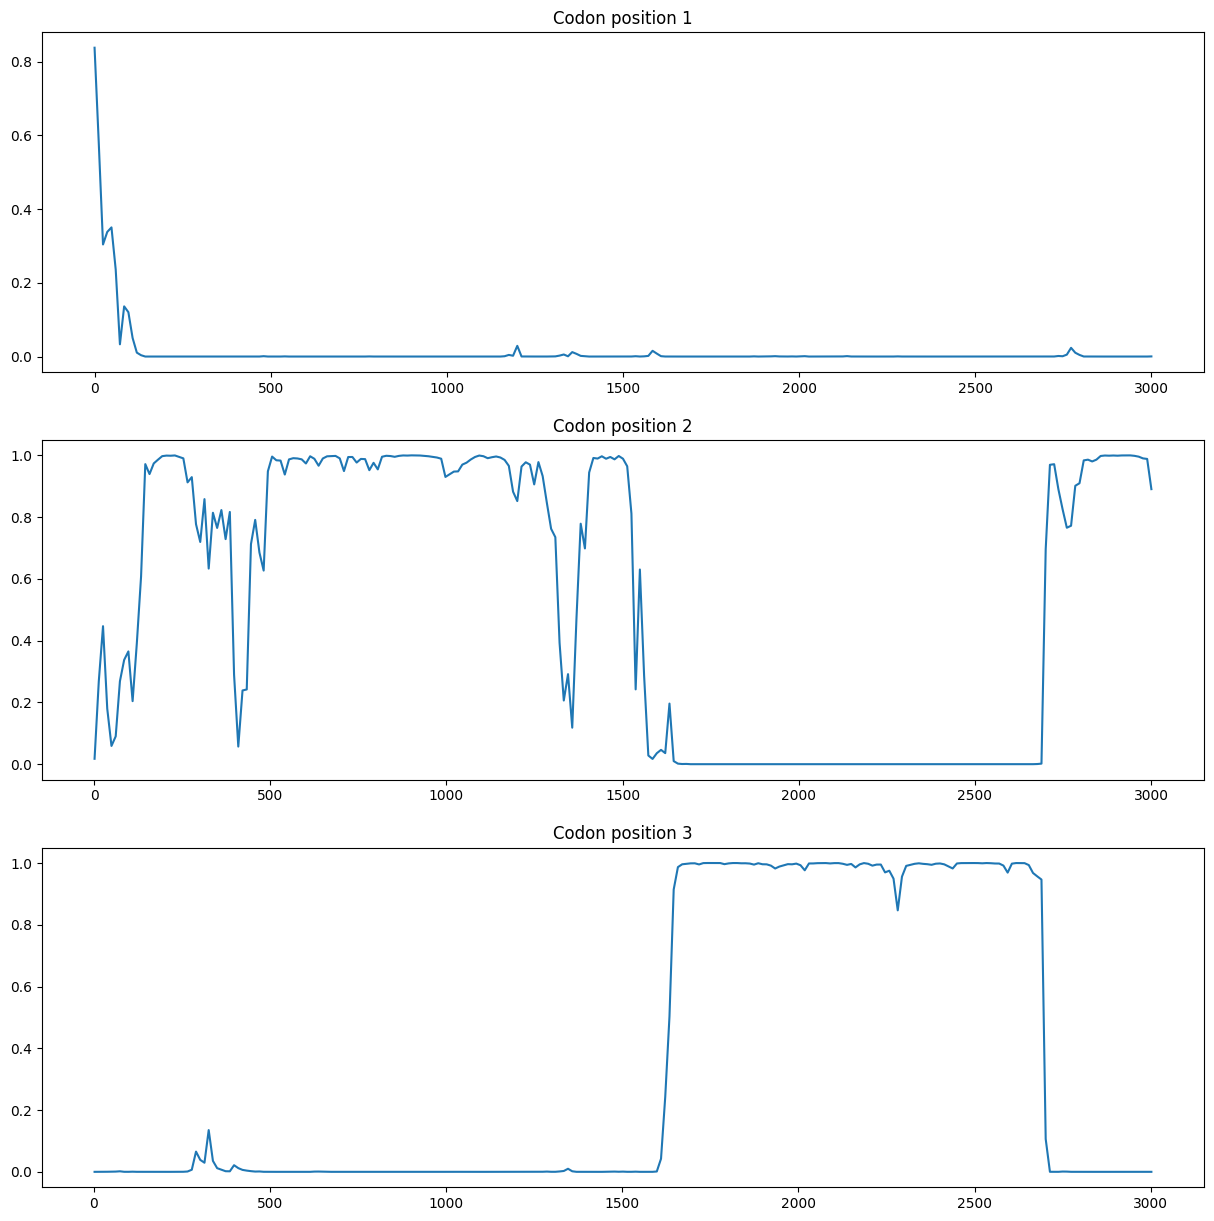

In [9]:
def plot_graph(probs, start, end, step):
  fig, ax = plt.subplots(3, 1, figsize=(15, 15))

  for i, subplot in enumerate(ax):
    subplot.plot(range(start+i, end+i, step), probs[i])
    subplot.set_title(f'Codon position {i+1}')

def get_pos_probs(sequence, start, end, step, window):
  pos_probs = [[] for __ in range(3)]
  for i in range(start, end, step):
    seq_96 = sequence[i:i+window]
    probs = get_cod_probs(seq_96, t1, t2)
    for j in range(3):
      pos_probs[j].append(probs[j] / sum(probs))
      #pos_probs[j].append(P_cod*probs[j]/(P_cod*probs[0] + P_cod*probs[1] + P_cod*probs[2] + P_nc*probs[3]))
  return pos_probs, start, end, step

plot_graph(*get_pos_probs(seq, 0, 3001, 12, 96))

Бонус 1


Функции для получения троек нуклеотидов (кодонов), старт и стоп кодонов, открытых рамок чтения


Согласно https://ftp.ncbi.nih.gov/entrez/misc/data/gc.prt, у нашей бактерии возможно 7 старт- и 3 стоп-кодона

In [11]:
from itertools import islice


def get_codons(sequence):
  iterator = iter(sequence)
  while len(batch := ''.join(islice(iterator, 3))) == 3:
    yield batch

def get_start_stop_codons(sequence):
  starts, stops = [], []
  for i, codon in enumerate(get_codons(sequence)):
    if codon in ('TTG', 'CTG', 'ATT', 'ATC', 'ATA', 'ATG', 'GTG'):
      starts.append(i*3)
    elif codon in ('TAA', 'TAG', 'TGA'):
      stops.append(i*3)
  return starts, stops

def get_orfs(sequence):
  stop_index = 0
  prev_stop = -1
  starts, stops = get_start_stop_codons(sequence)
  orfs = []
  for s in starts:
    while stop_index < len(stops) and stops[stop_index] < s:
      stop_index += 1
    if stop_index == len(stops):
      if len(sequence) - s > 90:
        orfs.append((s, len(sequence)))
      break
    if stops[stop_index] - s > 90 and prev_stop != stops[stop_index]:
      orfs.append((s, stops[stop_index]))
      prev_stop = stops[stop_index]
  return orfs


Функция для графиков вероятностей по трём рамкам считывания со старт- и стоп-кодонами и открытыми рамками чтения

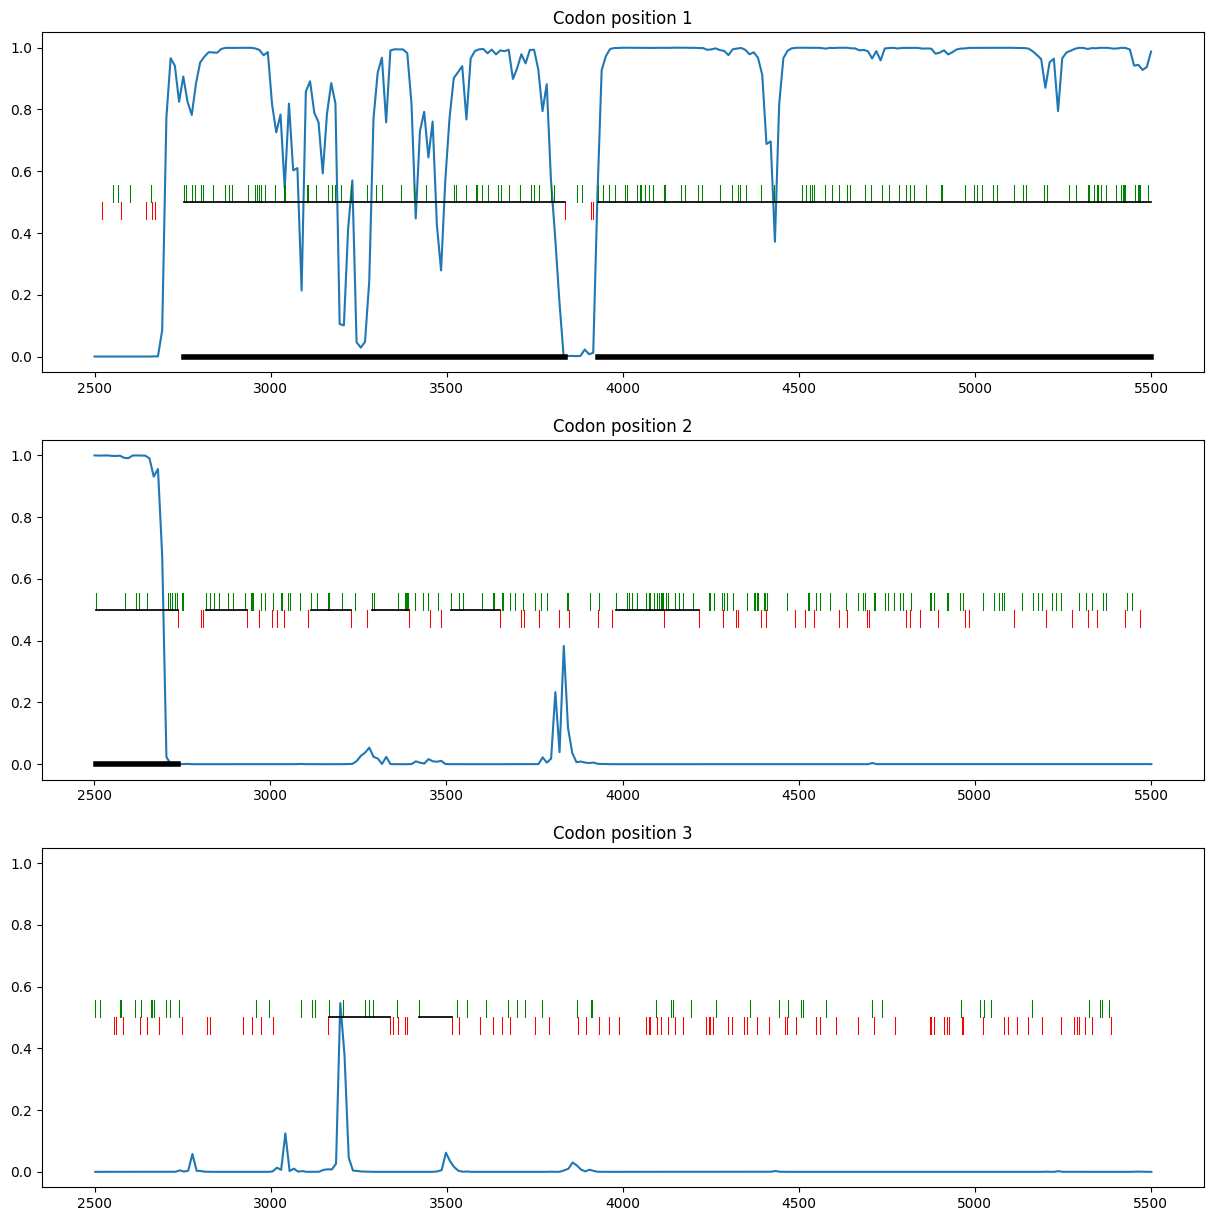

In [12]:
def plot_graph_orf(sequence, probs, s, e, step):
    fig, ax = plt.subplots(3, 1, figsize=(15, 15))

    for i, subplot in enumerate(ax):
      subplot.set_ylim(-0.05, 1.05)
      subplot.plot(range(s+i, e+i, step), probs[i]) 
      subplot.set_title(f'Codon position {i+1}')
      starts, stops = get_start_stop_codons(sequence[s+i:e+i])
      starts = map(lambda x: x+s, starts)
      stops = map(lambda x: x+s, stops)
      for pos in starts:
        subplot.axvline(pos, color='green', linewidth=0.75, ymin=0.5, ymax=0.55)
      for pos in stops:
        subplot.axvline(pos, color='red', linewidth=0.75, ymin=0.45, ymax=0.5)
      for orf in map(lambda x: (x[0]+s, x[1]+s), get_orfs(sequence[s+i:e+i])):
        subplot.plot(orf, (0.5, 0.5), color='black', linewidth=1.25)
        start_i, stop_i = map(lambda x: (x-s) // step, orf)
        if sum(probs[i][start_i:stop_i]) / len(probs[i][start_i:stop_i]) > 0.5:
          subplot.plot(orf, (0, 0), color='black', linewidth=4)

    plt.show()


plot_graph_orf(seq, *get_pos_probs(seq, 2500, 2500+3001, 12, 96))